In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Library as lb
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers

Training the model

In [92]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,    
  decay_steps=100,
  decay_rate=8,
  staircase=True)

def custom_loss(y_true, y_pred):
    return tf.keras.losses.cosine_similarity(y_true,y_pred) + 10*tf.keras.losses.huber(y_true,y_pred)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=0.001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=1000, batch_size=32):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=custom_loss,
                metrics=[
                  tf.keras.losses.MeanSquaredError("auto", "mean_squared_error")])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            validation_data=(x_test,y_test),
            callbacks=get_callbacks(name),
            batch_size = batch_size,
            verbose=2)

    return history

# Loading training dataset
folder = 'Burgers_time_cx'
input_train=np.load('../data/' + folder + '/input_train.npy')
input_test=np.load('../data/' + folder + '/input_test.npy')
output_train=np.load('../data/' + folder + '/output_train.npy')
output_test=np.load('../data/' + folder + '/output_test.npy')

INPUTDIM = (input_train.shape[1],input_train.shape[2])
OUTPUTDIM = (output_train.shape[1],)

verbose = True
p_dim = 512+128
n=3
k_max = 14

kernel_reg = 0.0001
dropout = 0.005

# Creting model
input_layer = layers.Input(shape = INPUTDIM, name= 'input_layer')
input_layer_flat = layers.Reshape((INPUTDIM[0]*INPUTDIM[1],)) (input_layer)
P_layer = layers.Dense(p_dim, activation='relu', kernel_regularizer = regularizers.l2(kernel_reg), name='P_layer') (input_layer_flat)
P_layer = layers.Dropout(dropout) (P_layer)
# Repeat the custom module 'n' times
for i in range(n):
    if verbose:
        print('Creating Fourier Layer ' +str(i))
    if i ==0:
        fourier_module_output = lb.Fourier_Layer(name='fourier_layer_'+str(i), k_max=k_max)(P_layer)
    else:
        fourier_module_output = lb.Fourier_Layer(name='fourier_layer_'+str(i), k_max=k_max)(fourier_module_output)

output_layer = layers.Dense(OUTPUTDIM[0], activation='linear', kernel_regularizer = regularizers.l2(kernel_reg), name='output_layer') (fourier_module_output)
output_layer= layers.Dropout(dropout) (output_layer)

if verbose:
    print('-------------------------------------------------------')
model = tf.keras.Model(inputs=input_layer, outputs = output_layer, name = 'Burgers_time_FNO')
if verbose:
    model.summary()

history = compile_and_fit(model, model.name, x_train=input_train, y_train=output_train, x_test=input_test, y_test=output_test, batch_size=256 , max_epochs=5000)



Creating Fourier Layer 0
fft_shape set: 14
ifft_shape set: 26
Bias layer has shape: 26
Creating Fourier Layer 1
fft_shape set: 14
ifft_shape set: 26
Bias layer has shape: 26
Creating Fourier Layer 2
fft_shape set: 14
ifft_shape set: 26
Bias layer has shape: 26
-------------------------------------------------------
Model: "Burgers_time_FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2, 65)]           0         
                                                                 
 reshape_1 (Reshape)         (None, 130)               0         
                                                                 
 P_layer (Dense)             (None, 640)               83840     
                                                                 
 dropout_2 (Dropout)         (None, 640)               0         
                                                               

In [65]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  5e-4,    
  decay_steps=50,
  decay_rate=12,
  staircase=False)

history_bis = compile_and_fit(model, model.name, x_train=input_train, y_train=output_train, x_test=input_test, y_test=output_test, batch_size=256 , max_epochs=3000)


Model: "Burgers_time_FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2, 65)]           0         
                                                                 
 reshape (Reshape)           (None, 130)               0         
                                                                 
 P_layer (Dense)             (None, 1024)              134144    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 fourier_layer_0 (Fourier_La  (None, 22)               22672     
 yer)                                                            
                                                                 
 fourier_layer_1 (Fourier_La  (None, 22)               628       
 yer)                                             

Epoch 1/3000
18/18 - 4s - loss: -9.3713e-01 - mean_squared_error: 0.0078 - val_loss: -9.5673e-01 - val_mean_squared_error: 0.0051 - 4s/epoch - 225ms/step
Epoch 2/3000
18/18 - 1s - loss: -9.4801e-01 - mean_squared_error: 0.0063 - val_loss: -9.5823e-01 - val_mean_squared_error: 0.0049 - 986ms/epoch - 55ms/step
Epoch 3/3000
18/18 - 1s - loss: -9.4867e-01 - mean_squared_error: 0.0062 - val_loss: -9.5849e-01 - val_mean_squared_error: 0.0049 - 987ms/epoch - 55ms/step
Epoch 4/3000
18/18 - 1s - loss: -9.4893e-01 - mean_squared_error: 0.0062 - val_loss: -9.5856e-01 - val_mean_squared_error: 0.0048 - 994ms/epoch - 55ms/step
Epoch 5/3000
18/18 - 1s - loss: -9.4889e-01 - mean_squared_error: 0.0062 - val_loss: -9.5860e-01 - val_mean_squared_error: 0.0048 - 1s/epoch - 56ms/step
Epoch 6/3000
18/18 - 1s - loss: -9.4858e-01 - mean_squared_error: 0.0062 - val_loss: -9.5862e-01 - val_mean_squared_error: 0.0048 - 1s/epoch - 57ms/step
Epoch 7/3000
18/18 - 1s - loss: -9.4888e-01 - mean_squared_error: 0.0061

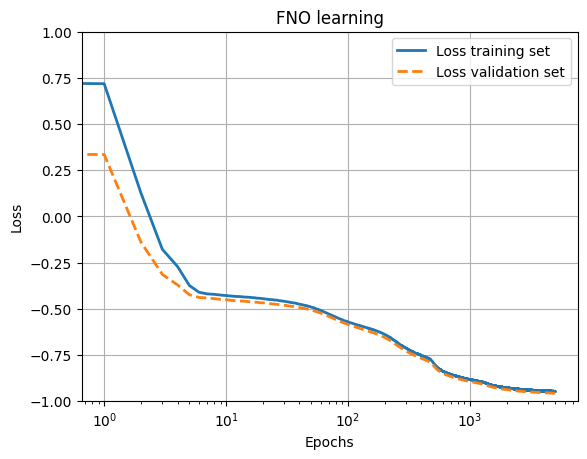

In [25]:
bc     = history.history['loss']
val_bc = history.history['val_loss']

plt.semilogx(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.semilogx(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('FNO learning')
plt.ylim([-1,1])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(('Loss training set','Loss validation set'))
plt.savefig('../Burgers_time_cx_FNO.png', dpi=300)
plt.show()

138/138 [==============================] - 1s 4ms/step


Text(0.5, 1.0, 'Training set - index: 1226')

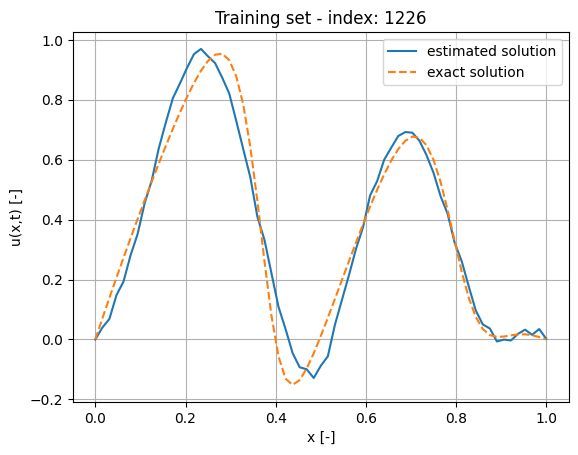

In [79]:
from random import randint

rec_output = model.predict(input_train)
index = randint(0, input_train.shape[0]-1)
xx=np.linspace(0,1,rec_output.shape[1])

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_train[index,:], label='exact solution', linestyle='--')
plt.legend()
plt.ylabel('u(x,t) [-]')
plt.xlabel('x [-]')
plt.title('Training set - index: '+ str(index))

46/46 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Test set - index: 352')

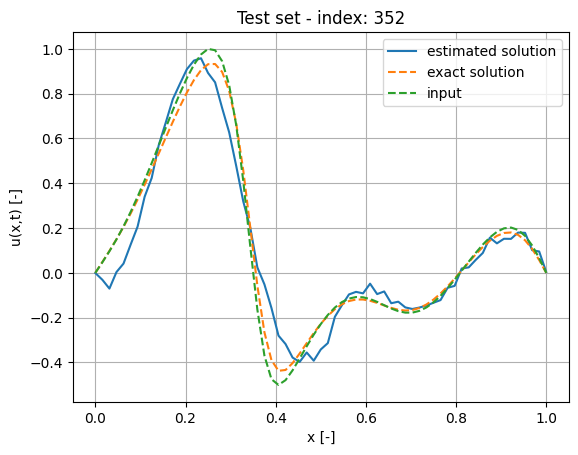

In [84]:
from random import randint

rec_output = model.predict(input_test)
index = randint(0, input_test.shape[0]-1)
xx=np.linspace(0,1,rec_output.shape[1])

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_test[index,:], label='exact solution', linestyle='--')
plt.plot(xx,input_test[index,0,:], label='input', linestyle='--')
plt.legend()
plt.ylabel('u(x,t) [-]')
plt.xlabel('x [-]')
plt.title('Test set - index: '+ str(index))

In [85]:
save_NN = False
# save_NN = True
if save_NN:
    model.save('../data/'+folder+'/Burgers_time_FNO_cx_bis.h5')
    print('FNO saved in '+str(folder))
else:
    print('FNO not saved')

FNO saved in Burgers_time_cx


Loading the model

In [86]:
folder = 'Burgers_time_cx'
loaded_model = keras.models.load_model('../data/'+folder+'/Burgers_time_cx_FNO.h5', compile=False)

fft_shape set: 12
ifft_shape set: 22
Bias layer has shape: 22
fft_shape set: 12
ifft_shape set: 22
Bias layer has shape: 22
fft_shape set: 12
ifft_shape set: 22
Bias layer has shape: 22


In [87]:
# Loading training dataset
input_train=np.load('../data/' + folder + '/input_train.npy')
input_test=np.load('../data/' + folder + '/input_test.npy')
output_train=np.load('../data/' + folder + '/output_train.npy')
output_test=np.load('../data/' + folder + '/output_test.npy')

46/46 [==============================] - 0s 4ms/step


Text(0.5, 1.0, 'Test set - index: 1')

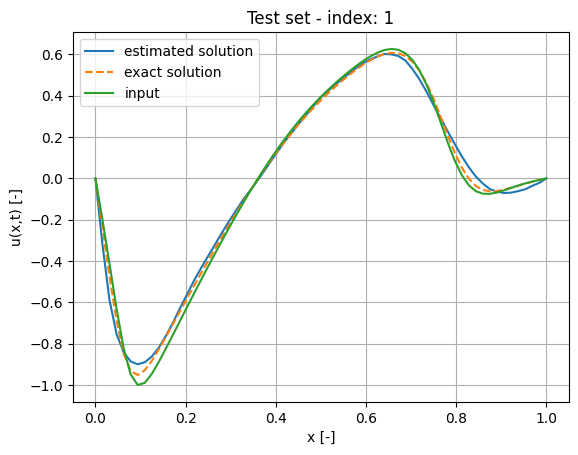

In [88]:
from random import randint
rec_output = loaded_model.predict(input_test)
index = randint(0, input_test.shape[0]-1)
index = 1
xx=np.linspace(0,1,rec_output.shape[1])

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_test[index,:], label='exact solution', linestyle='--')
plt.plot(xx,input_test[index,0,:], label='input')
plt.legend()
plt.ylabel('u(x,t) [-]')
plt.xlabel('x [-]')
plt.title('Test set - index: '+ str(index))
# plt.savefig('../Burgers_time_test_'+str(index)+'.png', dpi=300)

Improve training

In [89]:
lr_schedule(2896)

<tf.Tensor: shape=(), dtype=float32, numpy=7.1834955e-07>

In [90]:
# improve training
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  4e-6,    
  decay_steps=25,
  decay_rate=10,
  staircase=False)

def custom_loss(y_true, y_pred):
    return tf.keras.losses.cosine_similarity(y_true,y_pred) + 75*tf.keras.losses.huber(y_true,y_pred)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=0.001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=1000, batch_size=32):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=custom_loss,
                metrics=[
                  tf.keras.losses.MeanSquaredError("auto", "mean_squared_error")])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            validation_data=(x_test,y_test),
            callbacks=get_callbacks(name),
            batch_size = batch_size,
            verbose=2)

    return history

history = compile_and_fit(loaded_model, loaded_model.name, x_train=input_train, y_train=output_train, x_test=input_test, y_test=output_test, batch_size=256 , max_epochs=3000)



Model: "Burgers_time_FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2, 65)]           0         
                                                                 
 reshape_1 (Reshape)         (None, 130)               0         
                                                                 
 P_layer (Dense)             (None, 512)               67072     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 fourier_layer_0 (Fourier_La  (None, 22)               11408     
 yer)                                                            
                                                                 
 fourier_layer_1 (Fourier_La  (None, 22)               628       
 yer)                                             

Epoch 1/3000
18/18 - 4s - loss: -7.0213e-01 - mean_squared_error: 0.0071 - val_loss: -8.1735e-01 - val_mean_squared_error: 0.0042 - 4s/epoch - 215ms/step
Epoch 2/3000
18/18 - 1s - loss: -7.0835e-01 - mean_squared_error: 0.0069 - val_loss: -8.1737e-01 - val_mean_squared_error: 0.0042 - 705ms/epoch - 39ms/step
Epoch 3/3000
18/18 - 1s - loss: -7.0375e-01 - mean_squared_error: 0.0071 - val_loss: -8.1737e-01 - val_mean_squared_error: 0.0042 - 706ms/epoch - 39ms/step
Epoch 4/3000
18/18 - 1s - loss: -7.0621e-01 - mean_squared_error: 0.0070 - val_loss: -8.1737e-01 - val_mean_squared_error: 0.0042 - 679ms/epoch - 38ms/step
Epoch 5/3000
18/18 - 1s - loss: -7.0351e-01 - mean_squared_error: 0.0070 - val_loss: -8.1738e-01 - val_mean_squared_error: 0.0042 - 695ms/epoch - 39ms/step
Epoch 6/3000
18/18 - 1s - loss: -7.0355e-01 - mean_squared_error: 0.0070 - val_loss: -8.1738e-01 - val_mean_squared_error: 0.0042 - 703ms/epoch - 39ms/step
Epoch 7/3000
18/18 - 1s - loss: -7.0325e-01 - mean_squared_error: 

46/46 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Test set - index: 760')

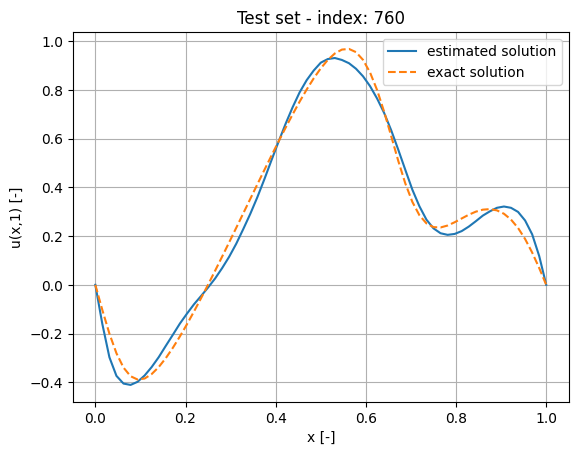

In [91]:
from random import randint
rec_output = loaded_model.predict(input_test)
# index = randint(0, input_test.shape[0]-1)
index = 760
xx=np.linspace(0,1,rec_output.shape[1])

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_test[index,:], label='exact solution', linestyle='--')
plt.legend()
plt.ylabel('u(x,1) [-]')
plt.xlabel('x [-]')
plt.title('Test set - index: '+ str(index))
# plt.savefig('../Burgers_time_test_'+str(index)+'.png', dpi=300)

Save the improved model

In [23]:
save_NN = False
# save_NN = True
if save_NN:
    loaded_model.save('../data/'+folder+'/Burgers_time_cx_FNO.h5')
    print('FNO saved in '+str(folder))
else:
    print('FNO not saved')

FNO saved in Burgers_time_cx
